# SDE
## *Simulating independent trajectories of a vector SDE*

$\newcommand{\rmd}{\textrm{d}}$
$\newcommand{\R}{\mathbb{R}}$
Consider a $n$-dimensional SDE:
$$
   dX_t = f(t,X_t)\,\rmd t + g(t,X_t)\,\rmd W_t\,,\quad t\in[0,T]
$$
where
- $X_t$ (resp. $W_t$) is of dimension $n$ (resp. $d$) 
- $W_t$ is a standard Brownian motion independent of $X_0$
- $f:\R\times \R^n\to \R^n$,  $g:\R\times \R^n\to \R^{n\times d}$

Indices are:
$$
X_t = [X_{t,i}]_{i=1:n}
\quad W_t = [W_{t,j}]_{j=1:d}
\quad f = [f_i]_{i=1:n}
\quad g=[g_{i,j}]_{i=1:n,j:1:d}
$$
I like also to simply write:
$$
X_t = X_{t,1:n}
\quad W_t = W_{t,1:d}
\quad f = f_{1:n}
\quad g = g_{1:n,1:d}
$$


> **Goal:** *generate $K$ independent trajectories $[0,T]\ni t \to X_t$*.

## Times discretization

We use an Euler-Maruyama scheme. Let $K$ given and:
$$
t_k := k\,\delta\,,\quad k=0:K
$$
where
$$
 \delta := \frac{T}{K}
$$
the approximation $\tilde X_k$ of $X_{t_k}$ is given by 
$$
  \tilde X_{k+1} = \tilde X_k + f(t_k,\tilde X_k)\,\delta + g(t_k,\tilde X_k)\,\sqrt{\delta}\,w_k
$$
where $w_k$ is i.i.d. $N(0,I_{d\times d})$ so that $\sqrt{\delta}\,w_k$ is an approximation of $W_{t_{k+1}}-W_{t_{k}}$. Here we suppose that $X_0=\tilde X_0=x$ given.


------------------
# Non vectorized implementation

*Easy to read but slow.*

In [1]:
import numpy as np

def simulate_sde_euler_maruyama(f, g, X0, T, N, R):
    """
    Simulate an SDE using the Euler-Maruyama scheme.

    Parameters:
        f: Function f(t, X) -> ndarray, drift term of SDE.
        g: Function g(t, X) -> ndarray of shape (n, d), diffusion term of SDE.
        X0: Initial condition, ndarray of shape (n,).
        T: Final time.
        N: Number of time steps.
        R: Number of independent realizations.

    Returns:
        t_vals: Array of time points.
        X_vals: Array of shape (R, N+1, n), simulated paths of X_t.
    """
    # Dimensions
    n = len(X0)  # Dimension of X
    dt = T / N  # Time step size
    t_vals = np.linspace(0, T, N+1)  # Time points
    
    # Initialize paths
    X_vals = np.zeros((R, N+1, n))
    X_vals[:, 0, :] = X0  # Set initial condition
    
    # Simulate R realizations
    for r in range(R):
        X = X0.copy()
        for i in range(N):
            t = t_vals[i]
            dW = np.random.normal(0, np.sqrt(dt), size=(n,))
            X = X + f(t, X) * dt + g(t, X).dot(dW)
            X_vals[r, i+1, :] = X

    return t_vals, X_vals

In [2]:
# Example usage
def f(t, X):
    return -X  # Example drift term

def g(t, X):
    return np.eye(len(X))  # Example diffusion term (identity matrix)

# Parameters
X0 = np.array([2.0, 0.0])  # Initial condition (2D system)
T = 1.0  # Final time
N = 100  # Number of time steps
R = 1000  # Number of realizations

t_vals, X_vals = simulate_sde_euler_maruyama(f, g, X0, T, N, R)

In [3]:
g(0,X0).shape


(2, 2)

# Graphics

In [4]:
import matplotlib.pyplot as plt

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set global font size for labels
plt.rcParams['axes.labelsize'] = 20  # Font size for x and y labels
plt.rcParams['axes.titlesize'] = 20  # Font size for title
plt.rcParams['xtick.labelsize'] = 15  # Font size for x-axis ticks
plt.rcParams['ytick.labelsize'] = 15  # Font size for y-axis ticks

# Set the global font to Roman (serif) family
#plt.rcParams['font.family'] = 'serif'

# Set the font for LaTeX-style text
#plt.rcParams['serif'] = ['Times New Roman']  # Or any Roman font you prefer

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


## Visualization of the paths (first coordinate)


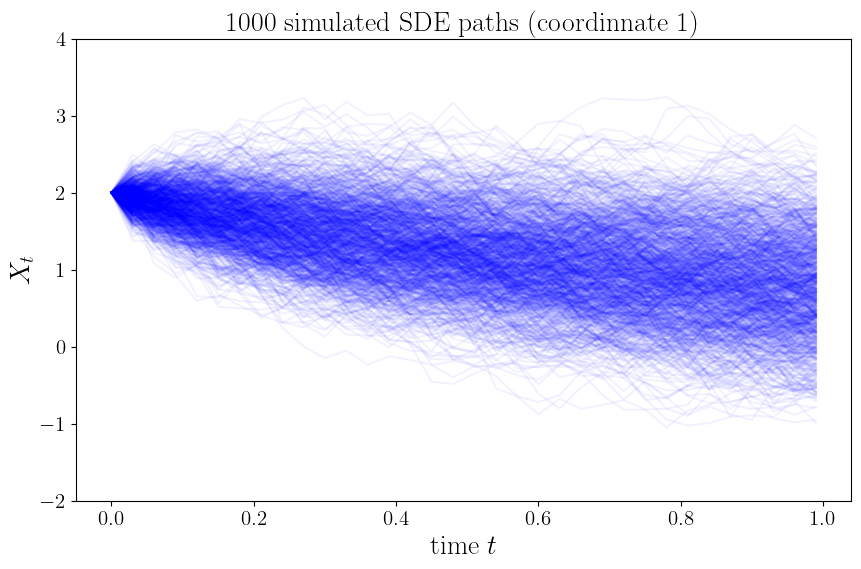

In [5]:
# --- we don't want to plot all the time steps
N_plots = 30              # number of times for plot
delta_plots = N//N_plots  # time steps between two plots

coordinate = 0

plt.figure(figsize=(10, 6))
for r in range(R):  # Plot first 10 realizations
    plt.plot(t_vals[::delta_plots], X_vals[r, ::delta_plots, coordinate], color='b', alpha=0.05)
plt.xlabel(r"time $t$")
plt.ylabel(r"$X_t$")
plt.title(rf"{R} simulated SDE paths (coordinnate {coordinate+1})")
plt.ylim(-2,4)
plt.show()

----
# Vectorized implementation

*Fast but difficult to read.*

In [6]:
import numpy as np

def simulate_sde_euler_maruyama_vectorized(f, g, X0, T, N, R):
    """
    Vectorized simulation of an SDE using the Euler-Maruyama scheme.

    Parameters:
        f: Function f(t, X) -> ndarray, drift term of SDE.
        g: Function g(t, X) -> ndarray of shape (n, d), diffusion term of SDE.
        X0: Initial condition, ndarray of shape (n,).
        T: Final time.
        N: Number of time steps.
        R: Number of independent realizations.

    Returns:
        t_vals: Array of time points.
        X_vals: Array of shape (R, N+1, n), simulated paths of X_t.
    """
    # Dimensions
    n = len(X0)  # Dimension of X
    dt = T / N  # Time step size
    t_vals = np.linspace(0, T, N+1)  # Time points

    # Initialize paths
    X_vals = np.zeros((R, N+1, n))
    X_vals[:, 0, :] = X0  # Set initial condition for all realizations

    # Generate Brownian increments for all realizations
    dW = np.random.normal(0, np.sqrt(dt), size=(R, N, n))  # Shape (R, N, n)

    # Vectorized iteration
    for i in range(N):
        t = t_vals[i]
        X = X_vals[:, i, :]  # Current state for all realizations
        drift = f(t, X)  # Shape (R, n)
        diffusion = np.einsum('ijk,ij->ik', g(t, X), dW[:, i, :])  # Shape (R, n)
        X_vals[:, i+1, :] = X + drift * dt + diffusion  # Update for all realizations

    return t_vals, X_vals

### Key Points of Optimization

1. Vectorized Brownian Increments: All Brownian increments are generated at once using `np.random.normal`.
2. Avoiding Loops Over Realizations: Drift and diffusion terms are computed for all realizations simultaneously using vectorized operations.
3. Efficient Diffusion Term: The matrix multiplication for the diffusion term $g(t,X)\,\Delta W_t$  is vectorized using `np.einsum`, which handles batched matrix-vector products efficiently.
4. Time Steps in a Single Loop: The only remaining loop is over time steps ($N$), which is necessary for the iterative nature of the scheme.

Why Vectorization is Faster
- Reduced Overhead: NumPy operations are implemented in C and highly optimized for performance.
- Batch Processing: Operations on large arrays are processed in parallel, leveraging CPU cache and vectorized instructions (SIMD).
- Fewer Python Function Calls: Reducing Python-level loops minimizes the interpreter overhead.



## Example usage

In [7]:
def f(t, X):
    return -X  # Example drift term

def g(t, X):
    return np.tile(np.eye(X.shape[1]), (X.shape[0], 1, 1))  # Example diffusion term (identity matrix)

# Parameters
X0 = np.array([1.0, 0.0])  # Initial condition (2D system)
T = 1.0  # Final time
N = 100  # Number of time steps
R = 1000  # Number of realizations

t_vals, X_vals = simulate_sde_euler_maruyama_vectorized(f, g, X0, T, N, R)

print("shape of t_vals = ",t_vals.shape)
print("shape of X_vals = ",X_vals.shape)

shape of t_vals =  (101,)
shape of X_vals =  (1000, 101, 2)


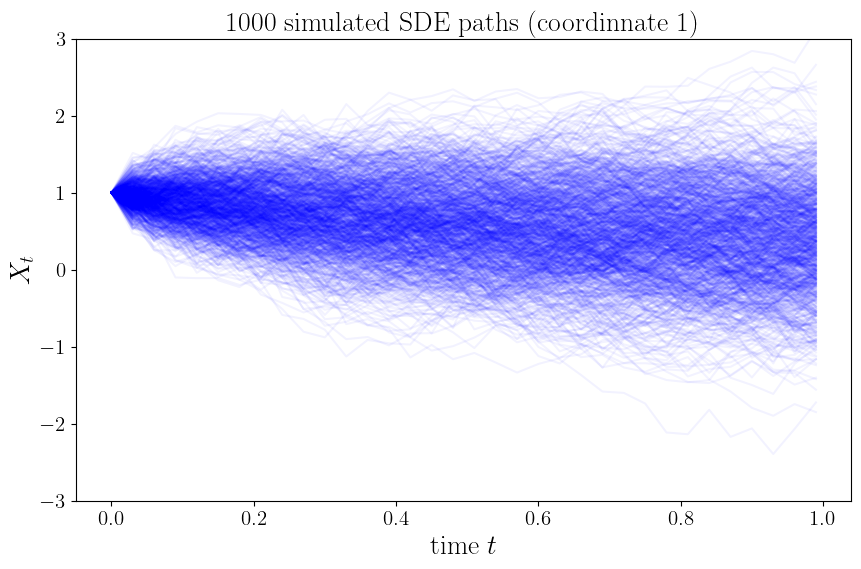

In [8]:
# Visualization of the paths (first dimension)
# --- we don't want to plot all the time steps
N_plots = 30              # number of times for plot
delta_plots = N//N_plots  # time steps between two plots

coordinate = 0

plt.figure(figsize=(10, 6))
for r in range(R):  # Plot first 10 realizations
    plt.plot(t_vals[::delta_plots], X_vals[r, ::delta_plots, coordinate], color='b', alpha=0.05)
plt.xlabel(r"time $t$")
plt.ylabel(r"$X_t$")
plt.title(rf"{R} simulated SDE paths (coordinnate {coordinate+1})")
plt.ylim(-3,3)
plt.show()



-----------------
# Going further 

To make the function simulate_sde_euler_maruyama_vectorized even faster, you can optimize it further by focusing on:

1. Reducing Python Overhead:

   - Minimize explicit Python loops (e.g., the loop over time steps).
   - Replace np.einsum with precomputed matrix operations where possible.


2. Batch Updates:

   - Instead of updating the solution one time step at a time, perform operations in bulk if the dynamics allow.

3. Leverage GPU Acceleration:

   - Use libraries like `CuPy` or `PyTorch` to take advantage of GPU parallelism for large $R$, $N$, or $n$.


4. Precomputing and Broadcasting:

   - Precompute any repetitive values (e.g., constant parts of $f$ or $g$).
   - Use broadcasting to avoid redundant calculations.


5. Optimize Memory Usage:

   - Instead of storing all $N+1$ time steps, store only those of interest or overwrite previous steps if intermediate values aren’t needed.

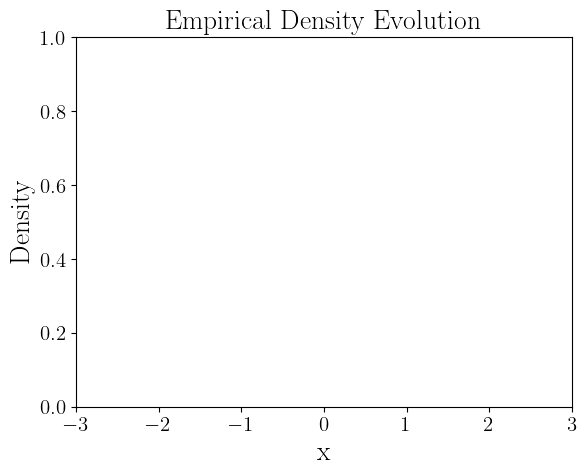

MovieWriter imagemagick unavailable; using Pillow instead.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.animation import FuncAnimation, PillowWriter

# Generate some sample data
# t_k: array of time instants
# x_k: array of shape (len(t_k), N), where N is the number of samples at each instant
np.random.seed(42)
t_k = np.linspace(0, 10, 100)  # Time instants
N = 100  # Number of points per instant
x_k = np.array([np.random.normal(loc=np.sin(t), scale=0.5, size=N) for t in t_k])

# Set up the plot
fig, ax = plt.subplots()
x_vals = np.linspace(-3, 3, 500)  # x-axis for density evaluation
line, = ax.plot([], [], lw=2)

ax.set_xlim(-3, 3)
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.set_title("Empirical Density Evolution")

# Animation update function
def update(k):
    ax.clear()
    kde = gaussian_kde(x_k[k])  # Compute KDE for the k-th sample
    density = kde(x_vals)
    
    ax.plot(x_vals, density, lw=2)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 1)
    ax.set_title(f"Empirical Density at t = {t_k[k]:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("Density")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_k), interval=100)
plt.show()
ani.save('density_evolution.gif', writer='imagemagick')

voir https://www.askpython.com/python-modules/animation-in-python-celluloid

https://github.com/jwkvam/celluloid



In [9]:
ani.save('density_evolution.gif', writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.


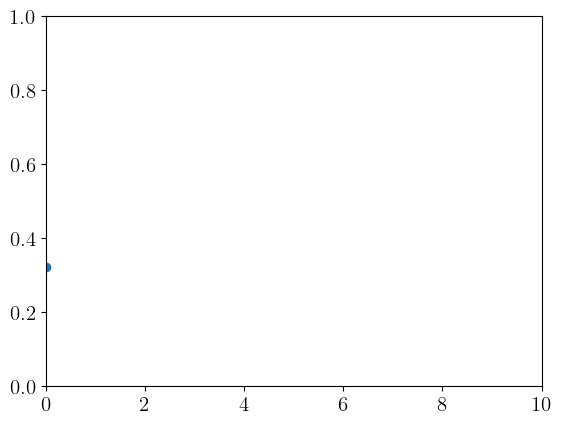

MovieWriter PillowWriter unavailable; using Pillow instead.


In [10]:
from matplotlib import pyplot as plt
from celluloid import Camera
import numpy as np


# create figure object
fig = plt.figure()
# load axis box
ax = plt.axes()
# set axis limit
ax.set_ylim(0, 1)
ax.set_xlim(0, 10)

camera = Camera(fig)
for i in range(10):
    ax.scatter(i, np.random.random())
    plt.pause(0.1)
    camera.snap()

animation = camera.animate()
animation.save('animation.gif', writer='PillowWriter', fps=2)

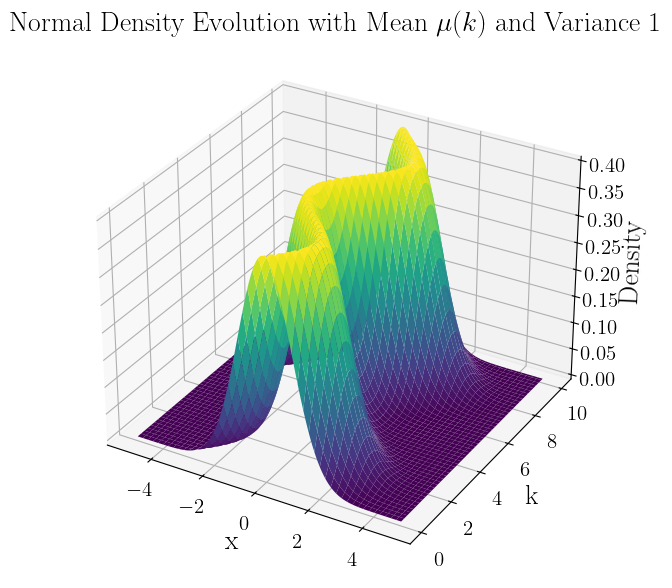

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Define parameters
k_values = np.linspace(0, 10, 100)  # k values
x_values = np.linspace(-5, 5, 500)  # x values

# Define the mean function mu(k)
def mu(k):
    return np.sin(k)  # Example: mean varies sinusoidally with k

# Compute the normal densities
densities = np.array([norm.pdf(x_values, loc=mu(k), scale=1) for k in k_values])

# Create the 3D surface plot
X, K = np.meshgrid(x_values, k_values)  # Grid for x and k

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the density surface
ax.plot_surface(X, K, densities, cmap='viridis', edgecolor='none')

# Customize the plot
ax.set_xlabel('x')
ax.set_ylabel('k')
ax.set_zlabel('Density')
ax.set_title('Normal Density Evolution with Mean $\mu(k)$ and Variance 1')

plt.show()


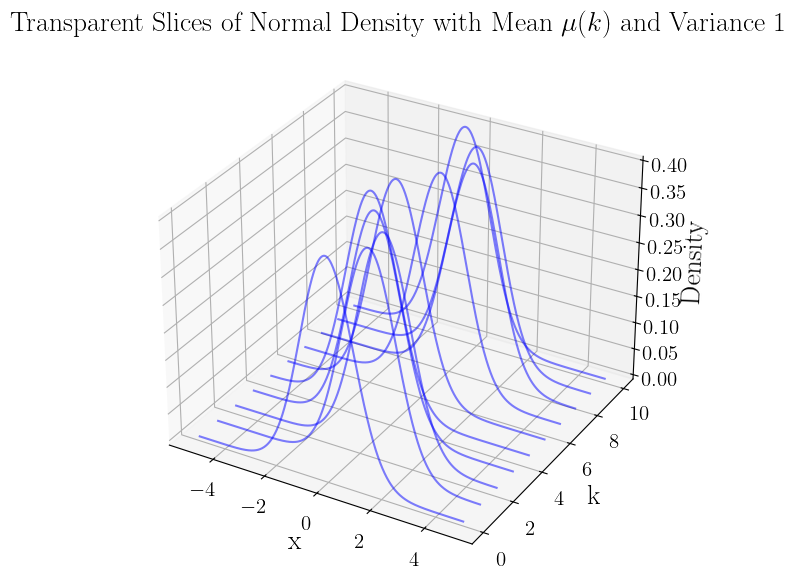

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Define parameters
k_values = np.linspace(0, 10, 10)  # k values
x_values = np.linspace(-5, 5, 500)  # x values

# Define the mean function mu(k)
def mu(k):
    return np.sin(k)  # Example: mean varies sinusoidally with k

# Compute the normal densities
densities = np.array([norm.pdf(x_values, loc=mu(k), scale=1) for k in k_values])

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each density as a transparent slice
for i, k in enumerate(k_values):
    ax.plot(x_values, [k] * len(x_values), densities[i], alpha=0.5, color='blue')

# Customize the plot
ax.set_xlabel('x')
ax.set_ylabel('k')
ax.set_zlabel('Density')
ax.set_title('Transparent Slices of Normal Density with Mean $\mu(k)$ and Variance 1')

plt.show()


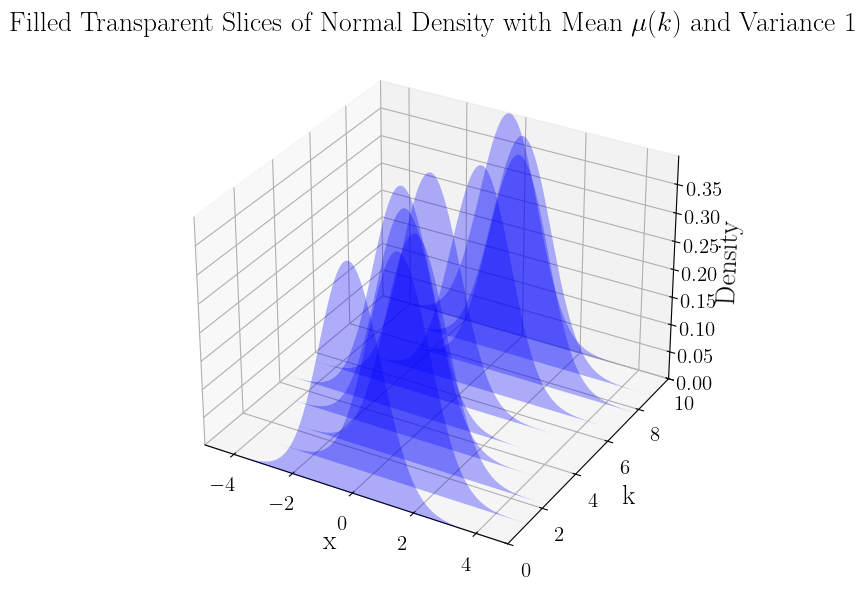

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define parameters
k_values = np.linspace(0, 10, 10)  # k values
x_values = np.linspace(-5, 5, 500)  # x values

# Define the mean function mu(k)
def mu(k):
    return np.sin(k)  # Example: mean varies sinusoidally with k

# Compute the normal densities
densities = np.array([norm.pdf(x_values, loc=mu(k), scale=1) for k in k_values])

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each density as a filled transparent slice
for i, k in enumerate(k_values):
    z = densities[i]
    x = x_values
    y = np.full_like(x, k)

    # Create vertices for the polygon to fill under the curve
    vertices = [(x[j], y[j], z[j]) for j in range(len(x))] + [(x[j], y[j], 0) for j in reversed(range(len(x)))]
    poly = Poly3DCollection([vertices], alpha=0.3, color='blue', edgecolor='none')
    ax.add_collection3d(poly)

# Customize the plot
ax.set_xlabel('x')
ax.set_ylabel('k')
ax.set_zlabel('Density')
ax.set_title('Filled Transparent Slices of Normal Density with Mean $\mu(k)$ and Variance 1')

# Set axis limits for better visibility
ax.set_xlim(x_values.min(), x_values.max())
ax.set_ylim(k_values.min(), k_values.max())
ax.set_zlim(0, densities.max())

plt.show()


(1000, 101, 2)

In [43]:
X_vals[0,::2,0]

array([1.        , 0.81384957, 0.60731957, 0.77969141, 1.0960614 ,
       1.07692777, 1.03591949, 1.13011673, 1.22370035, 1.17494816,
       1.14291806, 1.12937614, 0.93050483, 1.20348048, 1.09309411,
       0.95631486, 1.00124632, 0.97169893, 0.76461682, 1.00485564,
       1.24441813, 1.08362792, 1.09637842, 1.08036384, 1.06070659,
       0.89717707, 0.92456655, 0.99070043, 0.80467475, 1.1172211 ,
       1.08627221, 1.05990225, 1.27727958, 1.1969102 , 1.48449777,
       1.6151304 , 1.47311626, 1.56821064, 1.59331719, 1.33019067,
       1.13210513, 0.98689057, 0.83840771, 0.74026663, 0.65484123,
       0.70262627, 0.5792709 , 0.57265638, 0.63650679, 0.49144566,
       0.5236717 ])

9